## Empirical Examples from Kim, 1987

### 1. Import libraries

In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import operator as op
from functools import reduce
import spm1d

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### 2. Cutting functions: Class definition

In [2]:
# the class allow to define both cutting functions and permutations, in order to execute a bisection method or randomly
class CPfunctions():
    def __init__(self, 
                 Ndata, cut = None, perm = None):
        self.N = Ndata   # size of the data
    def permutation(self, random = False):
        """
        Define the permutation index for a bisection method, or in a random fashion if random is True
        """
        N = self.N
        K = np.arange(1,N+1)
        new_K = []
        if random:
            np.random.shuffle(K)
            new_K = K
        else:
            k_first = list(K)
            k_first.sort()
            K_List = [k_first]
            K_marker = [0]  # index that says if the corresponding K_List has been partitioned or not

            for i in range(N):
                # choose list to divide
                for j in range(len(K_List)):
                    if K_marker[j] == 0 and len(K_List[j]) >= 1:
                        length_K = len(K_List[j])
                        # choose position of new_K in the list
                        K_position = (length_K+1)//2 -1   # the middle (even) or the first integer greater than the middle (odd)
                        new_K.append(K_List[j][K_position])
                        # split the existing array            
                        K_List.append(K_List[j][:K_position])
                        K_List.append(K_List[j][K_position+1:])
                        K_marker[j] = 1
                        K_marker.append(0)
                        K_marker.append(0)
                        # now add elements to H_new
                        break
                        
        self.perm = np.array(new_K)
        
    def cutting(self, random = False):
        N = self.N
        H = np.random.randint(0, 2, N)
        K = self.perm
        new_H = H
        if not random:            
            H_counter = []   # counter to asign values of H
            h = 0
            while sum(H_counter) <= len(new_H):
                H_counter.append(2**h)
                h = h+1

            H_value = [0]*len(H_counter)    # values of H to asign
            for i in range(len(H_value)):
                if i%2 == 1:
                    H_value[i] = 1

            # for each element in K, asign the corresponding element in H

            for i in range(N):
                for m in range(len(H_value)):
                    if i+1 <= sum(H_counter[:m+1]):
                        new_H[K[i]-1] = H_value[m]
                        break
                        
        self.cut = np.array(new_H)


### 3. Blocks: Class definition

### Let's define a class to work with the blocks

In [3]:
class block():
    def __init__(self, 
                 vertices = None, 
                 elements = None, 
                 stats = None, 
                 parent = None, 
                 leftChild = None, 
                 rightChild = None, 
                 prefChild = None):
        self.vertices = vertices   # array with 2 bidimensional elements, corresponding to the vertices of the block
                                   # vertices must be ordered starting from the left bottom vertix and finishing with the
                                   # right top vertix
                                   # the array must have two rows and two columns (bidimensional case)
        self.elements = elements   # array with the points that belong to the block. Each row contains an element and each
                                   # column is a dimension (in this case, bidimensional)
        self.stats = np.sort(stats) # array with index of blocks
        self.parent = parent       # parent of the block
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.prefChild = prefChild
    
    def plot(self, color = 'C0', lw = 1, size = 12, print_num = True):
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[0,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[1,0], self.vertices[:,1], color = color, lw = lw)
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[1,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[0,0], self.vertices[:,1], color = color, lw = lw)
        xplot = (self.vertices[0,0]+self.vertices[1,0])/2
        yplot = (self.vertices[0,1]+self.vertices[1,1])/2
        if self.stats.size == 1 and print_num:
            plt.text(xplot, yplot, str(self.stats[0]), fontsize = size)

        
    def split(self, axis, korder):
        """
        This method split a Block and creates two child blocks, making the partition on the korder th statistic
        axis: indicates wheter it is along the X axis (vertical, 0) or the Y axis (horizontal, 1)
        korder: is the order statistic to make the partition
        """
        # select the dimension to sort
        Xele = self.elements[:,axis]
        # select the kth order statistic
        Xorder = np.sort(Xele)
        minStat = min(self.stats)
        korder = korder - minStat
        xstat = Xorder[korder]
        # divide the stats
        statsL = self.stats[:korder+1]
        statsR = self.stats[korder+1:]
        # create the elements and vertices of each block
        Relements = np.empty((0, 2))
        Lelements = np.empty((0, 2))
        
        # add elements to vertices and elements for each case
        if axis == 0:
            Lvertices = np.array([self.vertices[0,:], [xstat, self.vertices[1,1]]])
            Rvertices = np.array([[xstat, self.vertices[0,1]], self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]  # chosen kth order 
        elif axis == 1:
            Lvertices = np.array([self.vertices[0,:], [self.vertices[1,0], xstat]])
            Rvertices = np.array([[self.vertices[0,0], xstat],self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]   # chosen kth order 
                
        # create the childs of the block
        Rchild = block(vertices = Rvertices, elements = Relements, stats = statsR, parent = self)  
        # right side or up side (the greaters elements)
        Lchild = block(vertices = Lvertices, elements = Lelements, stats = statsL, parent = self)   
        # left side or down side (the smaller elements)
        
        # asociate the childs to the parten
        self.rightChild = Rchild
        self.leftChild = Lchild
        self.prefChild = Pchild
        # return the place where the partition was made
        return xstat
    
    def belong(self, x):
        nx = x.shape[0]
        out = True
        for i in range(nx):
            out = out and self.vertices[0,i] < x[i] <= self.vertices[1,i]
        return out
        
        

In [4]:
# other functions to calculate distributions and order blocks

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

def prob_M_null(s, N, M):
    """
    Calculate probabilitie that exactly s of the ma's are 0, under H0
    N is the size of data that defined the blocks (therefore, s in {0,...,N})
    M is the size of new data that is being compared
    """    
    if N >= M-1 and s < N-M+1:
        return 0
    else:
        num = ncr(N+1, s)*ncr(M-1, N-s)
        den = ncr(M+N, N)
        return num/den
    
    return num/den

def order_blocks(Blocks):
    """
    order the final blocks, so in the list of blocks they will be on the order corresponding to their statistics
    """
    Blocks_Order = []
    N_Blocks = len(Blocks)
    Assigned_Blocks = 0
    i = 0
    while Assigned_Blocks < N_Blocks:
        if Blocks[int(i%N_Blocks)].stats[0] == Assigned_Blocks+1:
            Blocks_Order.extend([Blocks[i%N_Blocks]])
            Assigned_Blocks = Assigned_Blocks + 1
        i = i + 1  # search in another block
    return Blocks_Order

def counting_blocks(Blocks, data):
    """
    counts the number of elementos from data belonging to each block of the list Blocks
    """
    data_copy = np.copy(data)   # copy Y to eliminate the elements already assigned to a block
    Ma = np.zeros(len(Blocks))  # 

    # calculate the values of m_{alpha}
    for k in range(len(Blocks)):
        i = 0
        while i < data_copy.shape[0]:   # count the elements that belong to the k-th block
            if Blocks[k].belong(data_copy[i,:]):
                Ma[k] = Ma[k] + 1
                data_copy = np.delete(data_copy, i, axis = 0)  # eliminate to make a shorter search
                i = i - 1
            i = i + 1
    return Ma

def rank_by_blocks(blocks, countings):
    """
    vectors of ranking for each sample according to the constructed blocks
    """
    rank_flag = True
    rank_correction = 1
    ranks_1 = []
    ranks_2 = []
    for i in range(len(blocks)):
        if countings[i] == 0 & rank_flag:
            ranks_1.append(rank_correction)
            rank_correction += 1
            rank_flag = False
        elif countings[i] != 0 & rank_flag:
            ranks_2.extend(np.arange(rank_correction,rank_correction + countings[i]))
            rank_correction += countings[i]
            ranks_1.append(rank_correction)
            rank_correction += 1
            rank_flag = False
        elif countings[i] == 0:
            ranks_1.append(rank_correction)
            rank_correction += 1
        elif countings[i] != 0:
            ranks_2.extend(np.arange(rank_correction,rank_correction + countings[i]))
            rank_correction += countings[i]
            ranks_1.append(rank_correction)
            rank_correction += 1
    ranks_1.remove(ranks_1[-1])
    return ranks_1, ranks_2

def EB_test_stats(S_prob, alpha):
    """
    return the stats to evaluate the empty block test for a given confidence level alpha
    """
    
    CV = (np.abs(S_prob-alpha)).argmin()
    # if it is the last, do not do anything else
    if S_prob[CV] < alpha:
        CV -= 1
    # define probability of reject H0 when #empty blocks = index
    if CV == len(S_prob)-1:
        Pr = 0
    else:
        Pr = (alpha- S_prob[CV + 1])/(S_prob[CV]-S_prob[CV+1])

    return CV, Pr#, S_prob[CV+1]



### 4. Blocks from data X or Y
### We proceed to use the block class to apply the partition in an iterative loop

-4.85 4.85 -4.85 4.85
Variance 0.8012801249732793 1.19927827358588
Mean 0.6043285741789998 -0.2818905795179793


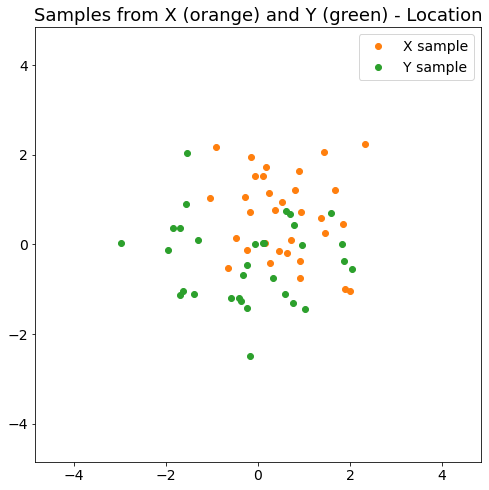

In [9]:
# data from kim

# number of samples per set. N for X, M for Y
N = 32
M = 32

models = {"dist":['Location', 'Scale', 'Mixture', 'Correlation'], "code":[0,1,2,3]}

# choose the code: 0 for Location; 1 for Scale; 2 for Mixture; 3 for Correlation.
code = 0

dist_type = models["dist"][code]

# define moments
meanX = 1.0*np.array([0,0])
meanX_1 = 0.85*np.array([1,1])
meanX_2 = -0.85*np.array([1,1])
covX = 1.0*np.array([[1,0],[0,1]])
meanY = 1.0*np.array([0,0])
covY = 1.0*np.array([[1,0],[0,1]])

# modify moments if necessary
if code == 0:
    meanX = 0.7*np.array([1,1])
elif code == 1:
    covY *= 3
elif code == 2:
    covX *= 0.281
else:
    covX = np.array([[1,-0.5],[-0.5,1]])
    covY = np.array([[1,0.5],[0.5,1]])

np.random.seed(100)   # 100 for location

#generate X data
X = np.random.multivariate_normal(meanX, covX, N)
if code == 2:
    X = np.concatenate((np.random.multivariate_normal(meanX_1, covX, int(N/2)),
                        np.random.multivariate_normal(meanX_2, covX, N-int(N/2))),
                        axis = 0)
# generate Y data
Y = np.random.multivariate_normal(meanY, covY, M)

# plot
fig = plt.figure(figsize=(8,8))
# Bloque.plot(color = 'g')
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', label = 'X sample')
plt.plot(Y[:,0], Y[:,1], 'o', color = 'C2', label = 'Y sample')
plt.legend(fontsize = 14)

fac = 1
Xmin = fac*min(meanX[0]-4*covX[0,0], meanX_1[0]-4*covX[0,0], meanX_2[0]-4*covX[0,0], meanY[0]-4*covY[0,0])
Xmax = fac*max(meanX[0]+4*covX[0,0], meanX_1[0]+4*covX[0,0], meanX_2[0]+4*covX[0,0], meanY[0]+4*covY[0,0])
Ymin = fac*min(meanX[1]-4*covX[1,1], meanX_1[1]-4*covX[1,1], meanX_2[1]-4*covX[1,1], meanY[1]-4*covY[1,1])
Ymax = fac*max(meanX[1]+4*covX[1,1], meanX_1[1]+4*covX[1,1], meanX_2[1]+4*covX[1,1], meanY[1]+4*covY[1,1])

plt.xlim(Xmin,Xmax)
plt.ylim(Ymin,Ymax)
print(Xmin, Xmax, Ymin, Ymax)
plt.title('Samples from X (orange) and Y (green) - '+dist_type, fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### SAVE FIGS

#fig.savefig('Examples/'+dist_type+'_samples.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('Examples/'+dist_type+'_samples.png', format='png', bbox_inches='tight')

### SAVE DATA
#np.savetxt('Examples/data_set_'+dist_type+'_X', X)
#np.savetxt('Examples/data_set_'+dist_type+'_Y', Y)

print('Variance', np.var(X), np.var(Y))
print('Mean', np.mean(X), np.mean(Y))


In [19]:
# create list with blocks

sample_sets = {'sets':[X,Y], 'names':['X', 'Y'], 'sample_code':[0,1]}

# choose the sample code: 0 to construct the blocks with the X samples; 1 with the Y samples.
sample_code = 1

sample_set = sample_sets['sets'][sample_code]
sample_name = sample_sets['names'][sample_code]

counter_code = (not sample_code)*1
counted_set = sample_sets['sets'][counter_code]
counter_name = sample_sets['names'][counter_code]

# define cutting functions and permutation order, blocks from data X
Lists = CPfunctions(sample_set.shape[0])
Lists.permutation()
Lists.cutting()
K = Lists.perm
H = Lists.cut

First_Block = block(vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]), elements = sample_set, stats = range(1,N+2))

Blocks_List = [First_Block]

step = sample_set.shape[0]

for i in range(step):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None:
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])
            break

### Now we plot the finals blocks

(array([-6., -4., -2.,  0.,  2.,  4.,  6.]),
 <a list of 7 Text major ticklabel objects>)

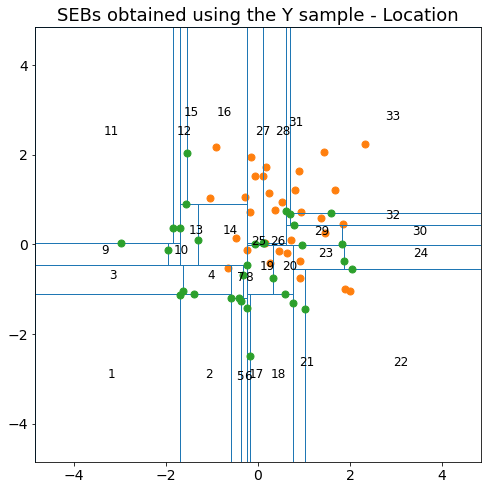

In [20]:
# plot
fig = plt.figure(figsize=(8,8))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

plt.xlim(Xmin,Xmax)
plt.ylim(Ymin,Ymax)

# create list of final blocks
Blocks_Final = []
block_ref = list()

for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_Final.extend([Blocks_List[j]])
        Blocks_List[j].plot(print_num = True)
        block_ref.append(Blocks_List[j].stats)
        
plt.plot(Y[:,0], Y[:,1], 'o', color = 'C2', ms = 7)
plt.title('SEBs obtained using the '+sample_name+' sample - '+dist_type, fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
        
#fig.savefig('Examples/'+dist_type+'_'+sample_name+'SEB.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('Examples/'+dist_type+'_'+sample_name+'SEB.png', format='png', bbox_inches='tight')


### 5. Test if both data come from the same distribution

19 0.1585729270124432 0.36439517615812805
20
The samples were generated from different distributions


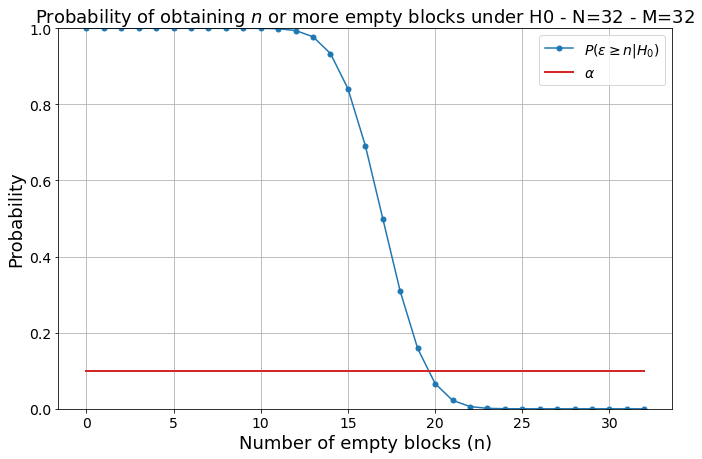

In [23]:
# order the blocks and count their elements
Blocks_Order = order_blocks(Blocks_Final)
Ma = counting_blocks(Blocks_Order, counted_set)

# let's calculate the S distribution, under H0

s_prob = np.zeros(sample_set.shape[0]+1)  # there are N + 1 blocks

for s in range(sample_set.shape[0]+1):
    s_prob[s] = prob_M_null(s, sample_set.shape[0], counted_set.shape[0])

# let's calculate the complement cumulative distribution, under H0 
# (we calculate the probability to have at least s m_a's that are 0)
S_prob = np.zeros(sample_set.shape[0]+1)
for s in range(sample_set.shape[0]+1):
    S_prob[s] = sum(s_prob[s:])
    
# confidence level
alpha = 0.1
    
fig = plt.figure(figsize=(11,7))
plt.plot(range(0, sample_set.shape[0]+1), S_prob, 'o-', color = 'C0', ms = 5, label = r'$P(\varepsilon \geq n|H_0)$')
plt.plot([0,sample_set.shape[0]], [alpha, alpha], '-', color = 'C3', lw = 2, label = r'$\alpha$')
plt.xlabel('Number of empty blocks (n)', fontsize = 18)
plt.ylabel('Probability', fontsize = 18)
plt.title(r'Probability of obtaining $n$ or more empty blocks under H0 - N='+str(N)+' - M='+str(M), fontsize = 18)
plt.ylim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)

#fig.savefig('Examples/cum-N'+str(N)+'-M'+str(M)+'.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('Examples/cum-N'+str(N)+'-M'+str(M)+'.png', format='png', bbox_inches='tight')

# find the element with significance level closer to alpha

index, Pindex = EB_test_stats(S_prob, alpha)
    
print(index, S_prob[index], Pindex)

# finally count the null elements
M_nulls = np.count_nonzero(Ma==0)
print(M_nulls)
if M_nulls > index:
    print('The samples were generated from different distributions')
elif M_nulls == index:  # reject H0 with probability Pindex
    Unif = np.random.uniform()
    if Unif < Pindex:   # uniform[0,1] distribution compared with Pindex
        # reject the hypothesis    
        print('The samples were generated from different distributions')
    else:
        print('The samples were generated from the same distribution')
else:
    print('The samples were generated from the same distribution')

### No we implement the Hotelling T2 test

In [ ]:
T2 = spm1d.stats.hotellings2(X,Y)
#print(T2)
alpha = 0.05
T2i = T2.inference(alpha)
print(T2i)
print(T2i.h0reject)
print(T2i.p)